# Defining imports

In [137]:
import cv2
import numpy as np
import sys
import math
# import os 
import glob
import matplotlib.pyplot as plt
import json

# Making functions

In [173]:
def Cropping(image):
    hight, width, _ = image.shape
    cropped_img = image[round(hight*0):round(hight), round(width*0.05):round(width*0.97)]
    return cropped_img

def Gray_scale(image):
    image_copy = image.copy()
    img_gray = cv2.cvtColor(image_copy, cv2.COLOR_BGR2GRAY)
    return img_gray

def Analyse_chessboard(img_col, img_gray, chess_board, objp, criteria):
    obj_points = []
    img_points  = []
    img_col_copy = img_col.copy()
    #Find the chess board corners
    # If desired number of corners are found in the image then ret = true
    ret, corners = cv2.findChessboardCorners(img_gray, chess_board, cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FAST_CHECK + cv2.CALIB_CB_NORMALIZE_IMAGE)
     
    """
    If desired number of corner are detected, we refine the pixel coordinates and display them on the images of checker board
    """
    
    if ret == True:
        obj_points.append(objp)
        # refining pixel coordinates for given 2d points.
        corners2 = cv2.cornerSubPix(img_gray, corners, (11,11),(-1,-1), criteria)
         
        img_points.append(corners2)
 
        # Draw and display the corners
        img = cv2.drawChessboardCorners(img_col_copy, chess_board, corners2, ret)

    return img, obj_points, img_points

def Print_camera_callibrtion(ret, mtx, dist, rvecs, tvecs):
    print("Error in projection :") #RMS re-projection error. 
    print(ret, "\n") 
    print("Intrinsic matrix : \n") # Intrinsic parameters
    print(mtx)
    print("\n dist : \n") # [k1, k2, p1, p2, k3] k:radial distortion, p: tangential distortion
    print(dist)
    print("\n rvecs : \n") # Extrinsic Rodriguez
    print(rvecs)
    print("\n tvecs : \n") # Extrinsic Translation vector
    print(tvecs)

def Make_extrinsic(rvec, tvecs):
    rotation_matrix = np.zeros(shape=(3,3))
    cv2.Rodrigues(rvec, rotation_matrix)
    print("Rotation matrix: \n", rotation_matrix)

    rotation_mask = np.array([[1, 0], [0, 1], [0, 0]])
    chopped_rotation = np.matmul(rotation_matrix, rotation_mask)
    extrinsic_matrix = np.hstack((chopped_rotation,tvecs))
    print("\nExtrinsic matrix: \n", extrinsic_matrix)

    return extrinsic_matrix

def Make_homography_matrix(exetric, intrinsic):
    homography_matrix = np.matmul(intrinsic, exetric)
    print("\nPre homography matrix: \n", homography_matrix)

    homography_matrix = homography_matrix/homography_matrix[2][2]
    print("\nPost homography matrix: \n", homography_matrix)
    return homography_matrix

def inv_homography(homography):
    inv_homography_matrix=np.linalg.inv(homography)
    print("\n Inverse homography matrix: \n", inv_homography_matrix)
    return inv_homography_matrix

def Undestor_images(img_path, mtx, dist, rvecs, tvecs, draw_frame = False):
    img_to_undistort  = cv2.imread(img_path)

    # Draw axes from world center point (use this when we need to draw on the original point)
    if draw_frame:
        cv2.drawFrameAxes(img_to_undistort, mtx, dist, rvecs[0], tvecs[0], length=7, thickness=3)
   
    # Refining the camera matrix:
    h,w = img_to_undistort.shape[:2]
    refined_camera_matrix, region_of_interest = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

    # Undistortion of the images
    img_distortion = cv2.undistort(img_to_undistort, mtx, dist, None, refined_camera_matrix)
    return img_distortion

def Blurring(image):
    return cv2.GaussianBlur(image, (7,7), 1)

def Threshdolding(Gray_image):
    thresholdValue = 55
    threshold, img_gray_segmented = cv2.threshold(Gray_image, thresholdValue , 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return img_gray_segmented

def Finding_contours(image):
    contours, _ = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    return contours

def Removing_outer_contoure(contours):
    list_contor = list()
    for kont in contours:
        area = cv2.contourArea(kont)
        #print(area)
        if area < 200000:
            list_contor.append(kont)
    return list_contor

def Draw_contours_in_original_img(contour, image):
    image = image.copy()
    contour_imag = cv2.drawContours(image, contour,-1, 100, 3)
    return contour_imag

def Find_center_of_objects(conts, img):
    dict_centers_2d = {}
    img_to_draw = img.copy()
    lable = 0
    for cont in conts:
        # calculate moments for each contour
        M = cv2.moments(cont)
        
        # calculate x,y coordinate of center
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        center = [cX, cY]
        cv2.circle(img_to_draw, (cX, cY), 5, (255, 255, 255), -1)
        lable += 1
        text = str(lable)
        dict_centers_2d[lable] = center
        cv2.putText(img_to_draw, text, (cX - 25, cY - 25),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
    return img_to_draw, dict_centers_2d
 
def From_2D_to_3D(center_2d):
    dict_center_3d = center_2d.copy()
    for key, value in dict_center_3d.items():
        value.append(1)
        dict_center_3d[key] = value

    return dict_center_3d

def From_pic_to_world_frame(pixels_to_calculate, inv_homo):
    world_points = {}
    for key, value in pixels_to_calculate.items():
        pre_point = np.dot(inv_homo, value)
        post_point = pre_point/pre_point[2]
        post_point_list  = post_point.tolist()
        world_points[key] = post_point_list
    return world_points

def Draw_frame_on_pic(img, mtx, dist, rvecs, tvecs):
    new_img= img.copy()
    cv2.drawFrameAxes(new_img, mtx, dist, rvecs[0], tvecs[0], length=7, thickness=3)
    return new_img





# Init

In [167]:
# Each tile is 7x7 mm
chekcerboard_tile_size = 7 #mm

# Because we have defined our grid in millimeters our output will also be in millimeters. 

# Vertical and horizontal 
CHECKERBOARD = (4,4) 
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Defining the world coordinates for 3D points
objp = np.zeros((1, CHECKERBOARD[0] * CHECKERBOARD[1], 3), np.float32)
objp[0,:,:2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)
objp *= chekcerboard_tile_size

# Camera calibration

Error in projection :
0.3333975937460799 

Intrinsic matrix : 

[[1.76373204e+03 0.00000000e+00 3.35661551e+02]
 [0.00000000e+00 1.76278863e+03 2.19615125e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

 dist : 

[[-3.32233762e+00  4.69117240e+02 -3.85795237e-02  3.64036887e-02
  -4.02216386e+03]]

 rvecs : 

(array([[-0.01261611],
       [-0.0345953 ],
       [ 0.00259581]]),)

 tvecs : 

(array([[ -9.29298442],
       [ -8.27212759],
       [210.18799883]]),)
Rotation matrix: 
 [[ 0.99939828 -0.00237702 -0.03460382]
 [ 0.00281343  0.99991706  0.01256835]
 [ 0.03457107 -0.01265814  0.99932208]]

Extrinsic matrix: 
 [[ 9.99398282e-01 -2.37701689e-03 -9.29298442e+00]
 [ 2.81342544e-03  9.99917057e-01 -8.27212759e+00]
 [ 3.45710732e-02 -1.26581400e-02  2.10187999e+02]]

Pre homography matrix: 
 [[ 1.77427495e+03 -8.44127176e+00  5.41616954e+04]
 [ 1.25518049e+01  1.75986250e+03  3.15784511e+04]
 [ 3.45710732e-02 -1.26581400e-02  2.10187999e+02]]

Post homography matrix: 
 [[ 8.441

(-0.5, 639.5, 479.5, -0.5)

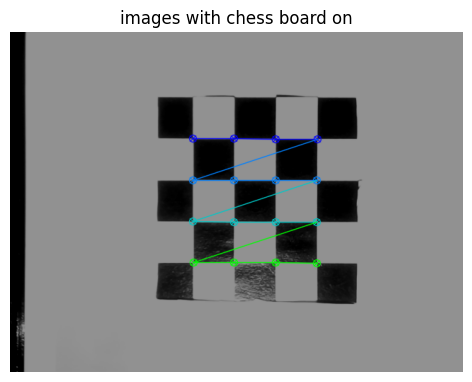

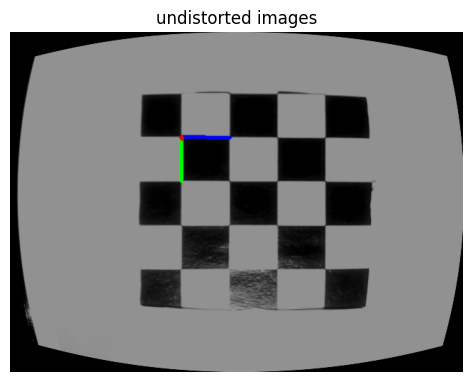

In [174]:
picture_path = "Images/ChessBoards/"
folder = "LimitedBoards2/"
file_name = "000001.bmp"
pic_name = picture_path + folder + file_name

img = cv2.imread(pic_name)
img_gr = Gray_scale(img)

img_sq, obj_points, img_points = Analyse_chessboard(img, img_gr, CHECKERBOARD, objp, criteria)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, img_gr.shape[::-1], None, None)
Print_camera_callibrtion(ret, mtx, dist, rvecs, tvecs)
ext_matrix = Make_extrinsic(rvecs[0], tvecs[0])
homo_matrix = Make_homography_matrix(ext_matrix, mtx)
inv_homo = inv_homography(homo_matrix)

undist_img = Undestor_images(pic_name, mtx, dist, rvecs, tvecs, draw_frame=True)

plt.figure(figsize=(30, 15))
plt.subplot(3,3,1)
plt.imshow(img_sq)
plt.title('images with chess board on')
plt.axis('off')

plt.figure(figsize=(30, 15))
plt.subplot(3,3,2)
plt.imshow(undist_img)
plt.title('undistorted images')
plt.axis('off')



# Preparing the images and finding objects

9
{
    "1": [
        8.220094295327868,
        30.702657301658707,
        1.0
    ],
    "2": [
        27.460421932797814,
        26.41999159044407,
        1.0
    ],
    "3": [
        -11.06926883343353,
        17.86176809523792,
        1.0
    ],
    "4": [
        8.065261699883635,
        16.169042308475294,
        1.0
    ],
    "5": [
        28.403435189277467,
        12.90767357751609,
        1.0
    ],
    "6": [
        7.3193921841167064,
        4.001170108554282,
        1.0
    ],
    "7": [
        31.151305421408672,
        -1.3580373082918025,
        1.0
    ],
    "8": [
        -5.57364719172545,
        -6.325028427517066,
        1.0
    ],
    "9": [
        15.416477926350966,
        -9.667188455424744,
        1.0
    ]
}


(-0.5, 639.5, 479.5, -0.5)

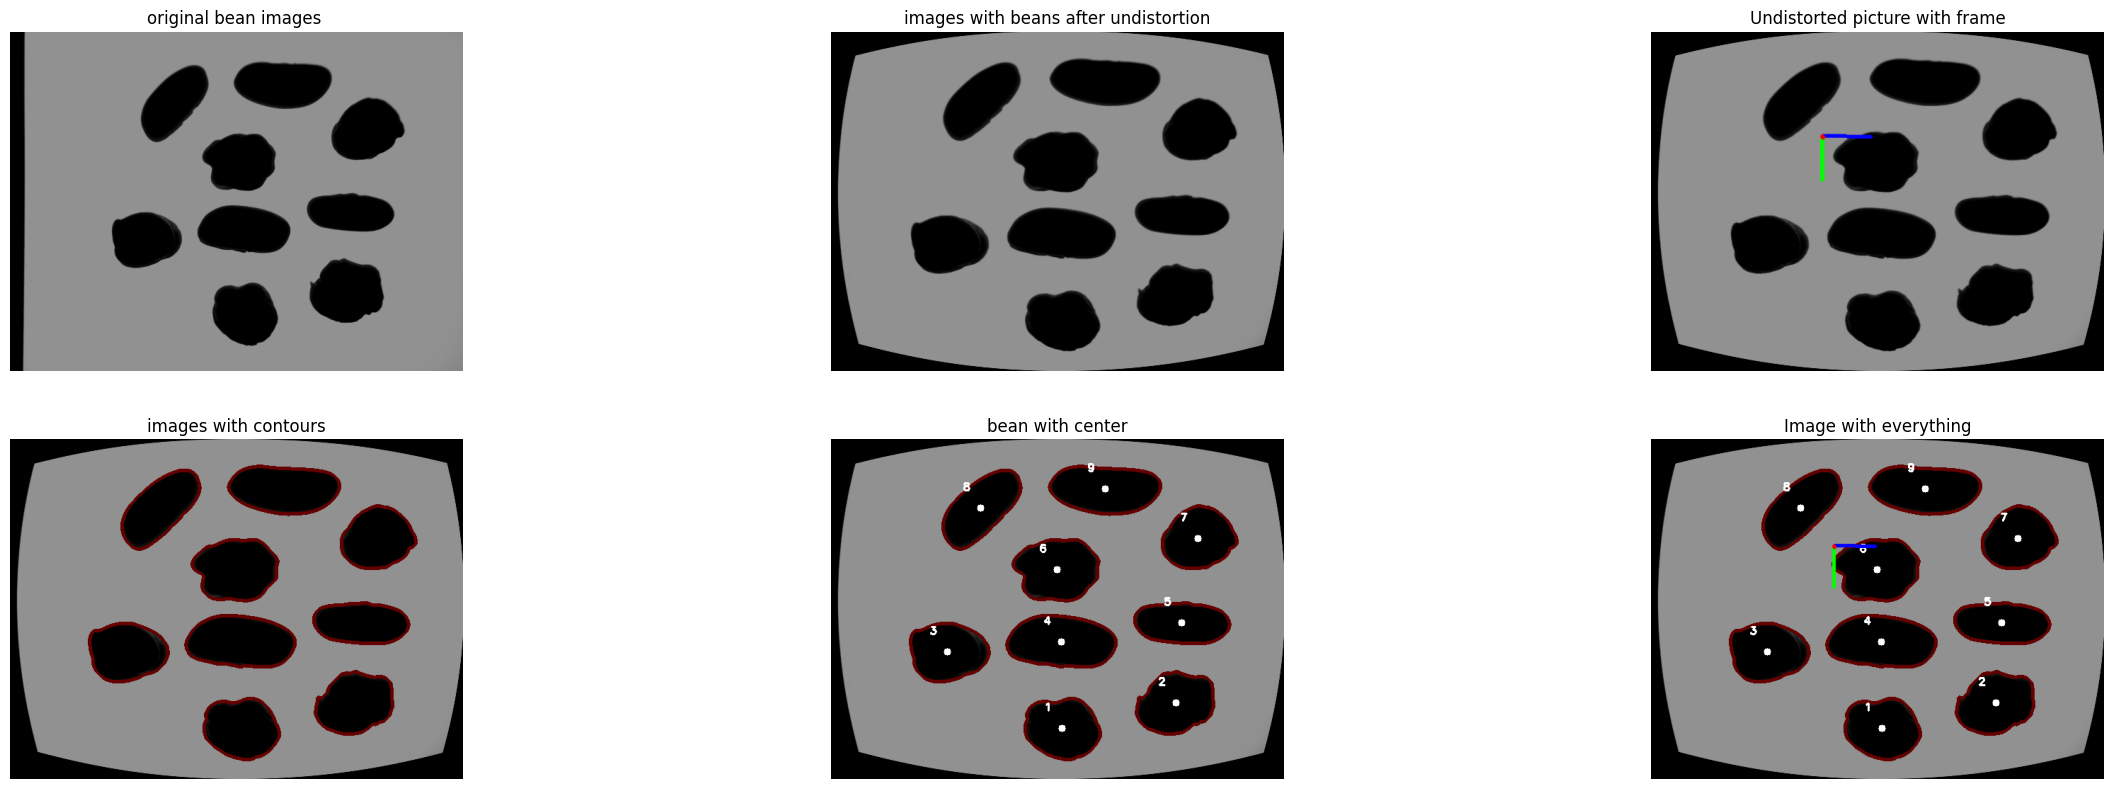

In [175]:
picture_path = "Images/ChessBoards/"
folder = "Beans/"
file_name = "000028.bmp"
pic_name = picture_path + folder + file_name

img_bean = cv2.imread(pic_name)

undist_img_bean_frame = Undestor_images(pic_name, mtx, dist, rvecs, tvecs, draw_frame=True)

undist_img_bean = Undestor_images(pic_name, mtx, dist, rvecs, tvecs, draw_frame=False)
undist_img_bean_blurred = Blurring(undist_img_bean)
undist_img_bean_gray = Gray_scale(undist_img_bean_blurred)
undist_img_bean_thrash = Threshdolding(undist_img_bean_gray)

contours = Finding_contours(undist_img_bean_thrash)
conts = Removing_outer_contoure(contours)
print(len(conts))
img_with_contour = Draw_contours_in_original_img(conts, undist_img_bean)

img_with_center, centers_2d = Find_center_of_objects(conts, img_with_contour)
center_3d = From_2D_to_3D(centers_2d)
world_coordinates = From_pic_to_world_frame(center_3d, inv_homo)

img_with_everything = Draw_frame_on_pic(img_with_center, mtx, dist, rvecs, tvecs)

clean_print = json.dumps(world_coordinates, indent=4, sort_keys=True)
print(clean_print)

plt.figure(figsize=(30, 15))
plt.subplot(3,3,1)
plt.imshow(img_bean)
plt.title('original bean images ')
plt.axis('off')

plt.subplot(3,3,2)
plt.imshow(undist_img_bean)
plt.title('images with beans after undistortion')
plt.axis('off')

plt.subplot(3,3,3)
plt.imshow(undist_img_bean_frame)
plt.title("Undistorted picture with frame")
plt.axis('off')

plt.subplot(3,3,4)
plt.imshow(img_with_contour)
plt.title('images with contours')
plt.axis('off')

plt.subplot(3,3,5)
plt.imshow(img_with_center)
plt.title('bean with center')
plt.axis('off')

plt.subplot(3,3,6)
plt.imshow(img_with_everything)
plt.title('Image with everything')
plt.axis('off')



In [172]:
# This is needed to find the (0,0) origin of the picture. [257.68214986 150.23907758   1.]
origin = [0,0,1]
pix_0 = np.dot(homo_matrix, origin)
pix_0 = pix_0/pix_0[2]
print(pix_0)

[257.68214986 150.23907759   1.        ]
